# Getting info on Priming experiment dataset that's needed for modeling

## Info:

* __Which gradient(s) to simulate?__
* For each gradient to simulate:
  * Infer total richness of starting community 
  * Get distribution of total OTU abundances per fraction
    * Number of sequences per sample
  * Infer total abundance of each target taxon

# User variables

In [2]:
baseDir = '/home/nick/notebook/SIPSim/dev/priming_exp/'
workDir = os.path.join(baseDir, 'exp_info')

otuTableFile = '/var/seq_data/priming_exp/data/otu_table.txt'
otuTableSumFile = '/var/seq_data/priming_exp/data/otu_table_summary.txt'

metaDataFile = '/var/seq_data/priming_exp/data/allsample_metadata_nomock.txt'

#otuRepFile = '/var/seq_data/priming_exp/otusn.pick.fasta'
#otuTaxFile = '/var/seq_data/priming_exp/otusn_tax/otusn_tax_assignments.txt'
#genomeDir = '/home/nick/notebook/SIPSim/dev/bac_genome1210/genomes/'

# Init

In [3]:
import glob

In [4]:
%load_ext rpy2.ipython

In [5]:
%%R
library(ggplot2)
library(dplyr)
library(tidyr)
library(gridExtra)
library(fitdistrplus)

/opt/anaconda/lib/python2.7/site-packages/rpy2/robjects/functions.py:106: UserWarning: 
Attaching package: ‘dplyr’


  res = super(Function, self).__call__(*new_args, **new_kwargs)
/opt/anaconda/lib/python2.7/site-packages/rpy2/robjects/functions.py:106: UserWarning: The following objects are masked from ‘package:stats’:

    filter, lag


  res = super(Function, self).__call__(*new_args, **new_kwargs)
/opt/anaconda/lib/python2.7/site-packages/rpy2/robjects/functions.py:106: UserWarning: The following objects are masked from ‘package:base’:

    intersect, setdiff, setequal, union


  res = super(Function, self).__call__(*new_args, **new_kwargs)
/opt/anaconda/lib/python2.7/site-packages/rpy2/robjects/functions.py:106: UserWarning: Loading required package: grid

  res = super(Function, self).__call__(*new_args, **new_kwargs)


In [6]:
if not os.path.isdir(workDir):
    os.makedirs(workDir)

# Loading OTU table (filter to just bulk samples)

In [46]:
%%R -i otuTableFile

tbl = read.delim(otuTableFile, sep='\t')

# filter
tbl = tbl %>%
    select(ends_with('.NA'))

tbl %>% ncol %>% print
tbl[1:4,1:4]

[1] 70
  X00C.000.14.09.NA X13C.100.14.08.NA X12C.700.28.04.NA X13C.000.45.04.NA
1                60                88                54                69
2                 1                 0                 0                 0
3                 0                 0                 0                 0
4                 0                 0                 0                 0


In [47]:
%%R

tbl.h = tbl %>% 
    gather('sample', 'count', 1:ncol(tbl)) %>%
    separate(sample, c('isotope','treatment','day','rep','fraction'), sep='\\.', remove=F)
tbl.h %>% head    

             sample isotope treatment day rep fraction count
1 X00C.000.14.09.NA    X00C       000  14  09       NA    60
2 X00C.000.14.09.NA    X00C       000  14  09       NA     1
3 X00C.000.14.09.NA    X00C       000  14  09       NA     0
4 X00C.000.14.09.NA    X00C       000  14  09       NA     0
5 X00C.000.14.09.NA    X00C       000  14  09       NA     1
6 X00C.000.14.09.NA    X00C       000  14  09       NA     0


# Which gradient(s) to simulate?

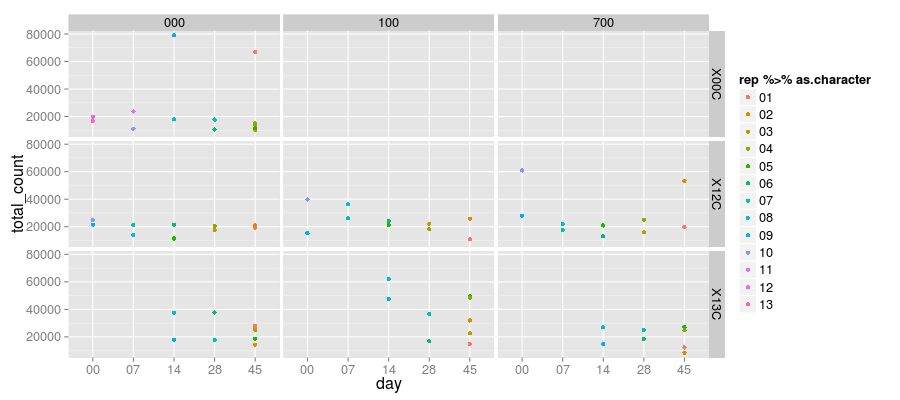

In [51]:
%%R -w 900 -h 400

tbl.h.s = tbl.h %>%
    group_by(sample) %>%
    summarize(total_count = sum(count)) %>%
    separate(sample, c('isotope','treatment','day','rep','fraction'), sep='\\.', remove=F)

ggplot(tbl.h.s, aes(day, total_count, color=rep %>% as.character)) +
    geom_point() +
    facet_grid(isotope ~ treatment) +
    theme(
        text = element_text(size=16)
        )

In [69]:
%%R
tbl.h.s$sample[grepl('700', tbl.h.s$sample)] %>% as.vector %>% sort

 [1] "X12C.700.00.09.NA" "X12C.700.00.10.NA" "X12C.700.07.07.NA"
 [4] "X12C.700.07.08.NA" "X12C.700.14.05.NA" "X12C.700.14.06.NA"
 [7] "X12C.700.28.03.NA" "X12C.700.28.04.NA" "X12C.700.45.01.NA"
[10] "X12C.700.45.02.NA" "X13C.700.14.08.NA" "X13C.700.14.09.NA"
[13] "X13C.700.28.06.NA" "X13C.700.28.07.NA" "X13C.700.45.01.NA"
[16] "X13C.700.45.02.NA" "X13C.700.45.03.NA" "X13C.700.45.04.NA"
[19] "X13C.700.45.05.NA"


#### Notes

Samples to simulate

* Isotope:
  * 12C vs 13C
* Treatment:
  * 700
* Days:
  * 14
  * 28
  * 45
 

In [10]:
%%R
# bulk soil samples for gradients to simulate

samples.to.use = c(
"X12C.700.14.05.NA",
"X12C.700.28.03.NA",
"X12C.700.45.01.NA",
"X13C.700.14.08.NA",
"X13C.700.28.06.NA",
"X13C.700.45.01.NA"
)

# Total richness of starting (bulk-soil) community

Method:

* Total number of OTUs in OTU table (i.e., gamma richness)
* Just looking at bulk soil samples

## Loading just bulk soil

In [29]:
%%R -i otuTableFile

tbl = read.delim(otuTableFile, sep='\t')

# filter
tbl = tbl %>%
    select(ends_with('.NA'))
tbl$OTUId = rownames(tbl)

tbl %>% ncol %>% print
tbl[1:4,1:4]

[1] 71
  X00C.000.14.09.NA X13C.100.14.08.NA X12C.700.28.04.NA X13C.000.45.04.NA
1                60                88                54                69
2                 1                 0                 0                 0
3                 0                 0                 0                 0
4                 0                 0                 0                 0


In [30]:
%%R

tbl.h = tbl %>% 
    gather('sample', 'count', 1:(ncol(tbl)-1)) %>%
    separate(sample, c('isotope','treatment','day','rep','fraction'), sep='\\.', remove=F)
tbl.h %>% head    

  OTUId            sample isotope treatment day rep fraction count
1     1 X00C.000.14.09.NA    X00C       000  14  09       NA    60
2     2 X00C.000.14.09.NA    X00C       000  14  09       NA     1
3     3 X00C.000.14.09.NA    X00C       000  14  09       NA     0
4     4 X00C.000.14.09.NA    X00C       000  14  09       NA     0
5     5 X00C.000.14.09.NA    X00C       000  14  09       NA     1
6     6 X00C.000.14.09.NA    X00C       000  14  09       NA     0


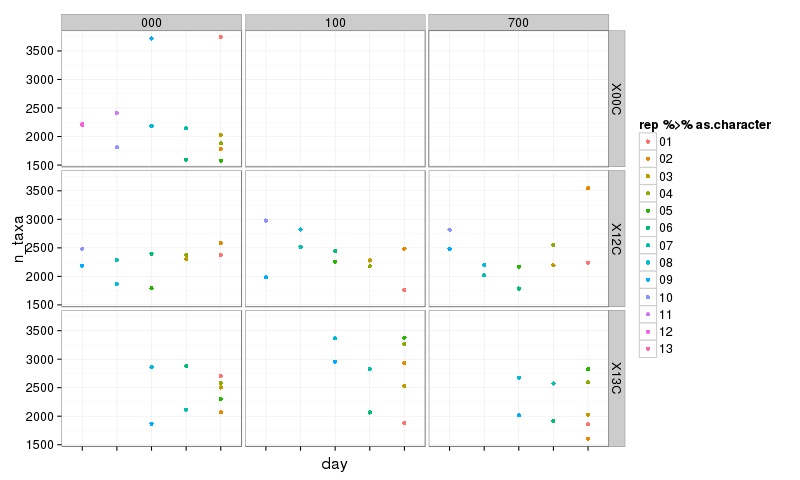

In [31]:
%%R -w 800
tbl.s = tbl.h %>% 
    filter(count > 0) %>%
    group_by(sample, isotope, treatment, day, rep, fraction) %>%
    summarize(n_taxa = n())

ggplot(tbl.s, aes(day, n_taxa, color=rep %>% as.character)) +
    geom_point() +
    facet_grid(isotope ~ treatment) +
    theme_bw() +
    theme(
        text = element_text(size=16),
        axis.text.x = element_blank()
        )

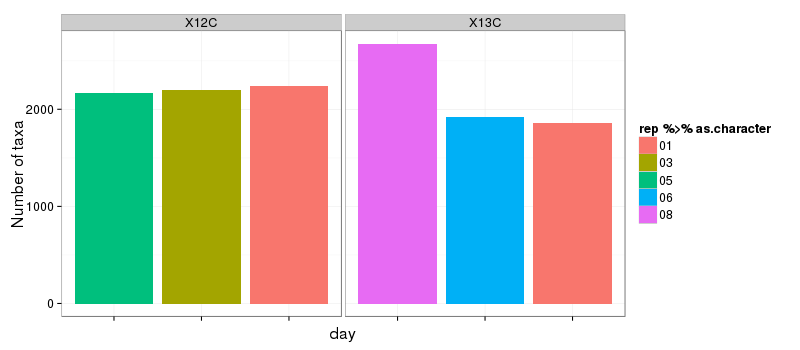

In [33]:
%%R -w 800 -h 350
# filter to just target samples

tbl.s.f = tbl.s %>% filter(sample %in% samples.to.use)

ggplot(tbl.s.f, aes(day, n_taxa, fill=rep %>% as.character)) +
    geom_bar(stat='identity') +
    facet_grid(. ~ isotope) +
    labs(y = 'Number of taxa') +
    theme_bw() +
    theme(
        text = element_text(size=16),
        axis.text.x = element_blank()
        )

In [82]:
%%R
message('Bulk soil total observed richness: ')

tbl.s.f %>% select(-fraction) %>% as.data.frame %>% print

Bulk soil total observed richness: 
             sample isotope treatment day rep n_taxa
1 X13C.700.28.06.NA    X13C       700  28  06   1917
2 X13C.700.14.08.NA    X13C       700  14  08   2677
3 X12C.700.28.03.NA    X12C       700  28  03   2194
4 X12C.700.45.01.NA    X12C       700  45  01   2239
5 X12C.700.14.05.NA    X12C       700  14  05   2170
6 X13C.700.45.01.NA    X13C       700  45  01   1858


### Number of taxa in all fractions corresponding to each bulk soil sample

* Trying to see the difference between richness of bulk vs gradients (veil line effect)

In [49]:
%%R -i otuTableFile
# loading OTU table
tbl = read.delim(otuTableFile, sep='\t') %>%
    select(-ends_with('.NA'))

tbl.h = tbl %>% 
    gather('sample', 'count', 2:ncol(tbl)) %>%
    separate(sample, c('isotope','treatment','day','rep','fraction'), sep='\\.', remove=F)
tbl.h %>% head  

      OTUId            sample isotope treatment day rep fraction count
1  OTU.4776 X12C.700.45.01.24    X12C       700  45  01       24   157
2  OTU.2864 X12C.700.45.01.24    X12C       700  45  01       24     0
3  OTU.8170 X12C.700.45.01.24    X12C       700  45  01       24     0
4  OTU.8762 X12C.700.45.01.24    X12C       700  45  01       24     0
5  OTU.5223 X12C.700.45.01.24    X12C       700  45  01       24     0
6 OTU.13091 X12C.700.45.01.24    X12C       700  45  01       24     0


In [56]:
%%R
# basename of fractions
samples.to.use.base = gsub('\\.[0-9]+\\.NA', '', samples.to.use)

samps = tbl.h$sample %>% unique

fracs = sapply(samples.to.use.base, function(x) grep(x, samps, value=TRUE))

for (n in names(fracs)){
    n.frac = length(fracs[[n]])
    cat(n, '-->', 'Number of fraction samples: ', n.frac, '\n')
}

X12C.700.14 --> Number of fraction samples:  20 
X12C.700.28 --> Number of fraction samples:  20 
X12C.700.45 --> Number of fraction samples:  20 
X13C.700.14 --> Number of fraction samples:  20 
X13C.700.28 --> Number of fraction samples:  22 
X13C.700.45 --> Number of fraction samples:  20 


In [79]:
%%R
# function for getting all OTUs in a sample
n.OTUs = function(samples, otu.long){
    otu.long.f = otu.long %>%
        filter(sample %in% samples,
               count > 0) 
    n.OTUs = otu.long.f$OTUId %>% unique %>% length
    return(n.OTUs)
}


num.OTUs = lapply(fracs, n.OTUs, otu.long=tbl.h)

num.OTUs = do.call(rbind, num.OTUs) %>% as.data.frame
colnames(num.OTUs) = c('n_taxa')
num.OTUs$sample = rownames(num.OTUs)
num.OTUs

            n_taxa      sample
X12C.700.14   6606 X12C.700.14
X12C.700.28   6896 X12C.700.28
X12C.700.45   6901 X12C.700.45
X13C.700.14   6005 X13C.700.14
X13C.700.28   6238 X13C.700.28
X13C.700.45   6325 X13C.700.45


In [75]:
%%R
tbl.s.f %>% as.data.frame

             sample isotope treatment day rep fraction n_taxa
1 X13C.700.28.06.NA    X13C       700  28  06       NA   1917
2 X13C.700.14.08.NA    X13C       700  14  08       NA   2677
3 X12C.700.28.03.NA    X12C       700  28  03       NA   2194
4 X12C.700.45.01.NA    X12C       700  45  01       NA   2239
5 X12C.700.14.05.NA    X12C       700  14  05       NA   2170
6 X13C.700.45.01.NA    X13C       700  45  01       NA   1858


In [91]:
%%R   
# joining with bulk soil sample summary table
num.OTUs$data = 'fractions'
tbl.s.f$data = 'bulk_soil'
tbl.j = rbind(num.OTUs,
              tbl.s.f %>% ungroup %>% select(sample, n_taxa, data)) %>%
    mutate(isotope = gsub('X|\\..+', '', sample),
           sample = gsub('\\.[0-9]+\\.NA', '', sample))
tbl.j

   n_taxa      sample      data isotope
1    6606 X12C.700.14 fractions     12C
2    6896 X12C.700.28 fractions     12C
3    6901 X12C.700.45 fractions     12C
4    6005 X13C.700.14 fractions     13C
5    6238 X13C.700.28 fractions     13C
6    6325 X13C.700.45 fractions     13C
7    1917 X13C.700.28 bulk_soil     13C
8    2677 X13C.700.14 bulk_soil     13C
9    2194 X12C.700.28 bulk_soil     12C
10   2239 X12C.700.45 bulk_soil     12C
11   2170 X12C.700.14 bulk_soil     12C
12   1858 X13C.700.45 bulk_soil     13C


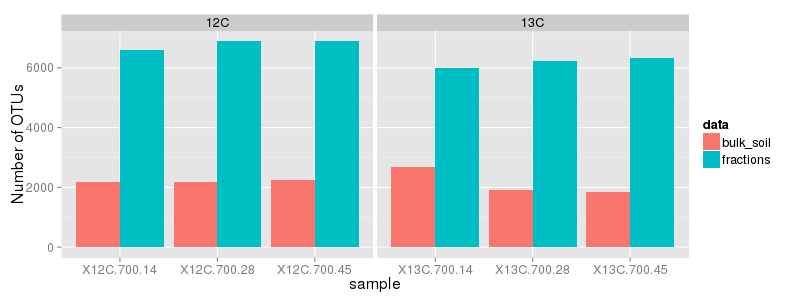

In [95]:
%%R -h 300 -w 800

ggplot(tbl.j, aes(sample, n_taxa, fill=data)) +
    geom_bar(stat='identity', position='dodge') +
    facet_grid(. ~ isotope, scales='free_x') +
    labs(y = 'Number of OTUs') +
    theme(
        text = element_text(size=16)
     #   axis.text.x = element_text(angle=90)
    )

# Distribution of total sequences per fraction
  
* Number of sequences per sample
* Using all samples to assess this one
* Just fraction samples

__Method:__

* Total number of sequences (total abundance) per sample

### Loading OTU table

In [145]:
%%R -i otuTableFile

tbl = read.delim(otuTableFile, sep='\t')

# filter
tbl = tbl %>%
    select(-ends_with('.NA'))

tbl %>% ncol %>% print
tbl[1:4,1:4]

[1] 398
     OTUId X12C.700.45.01.24 X12C.700.14.06.14 X12C.100.14.05.18
1 OTU.4776               157                34                13
2 OTU.2864                 0                 1                 2
3 OTU.8170                 0                 0                 0
4 OTU.8762                 0                 0                 0


In [146]:
%%R

tbl.h = tbl %>% 
    gather('sample', 'count', 2:ncol(tbl)) %>%
    separate(sample, c('isotope','treatment','day','rep','fraction'), sep='\\.', remove=F)
tbl.h %>% head    

      OTUId            sample isotope treatment day rep fraction count
1  OTU.4776 X12C.700.45.01.24    X12C       700  45  01       24   157
2  OTU.2864 X12C.700.45.01.24    X12C       700  45  01       24     0
3  OTU.8170 X12C.700.45.01.24    X12C       700  45  01       24     0
4  OTU.8762 X12C.700.45.01.24    X12C       700  45  01       24     0
5  OTU.5223 X12C.700.45.01.24    X12C       700  45  01       24     0
6 OTU.13091 X12C.700.45.01.24    X12C       700  45  01       24     0


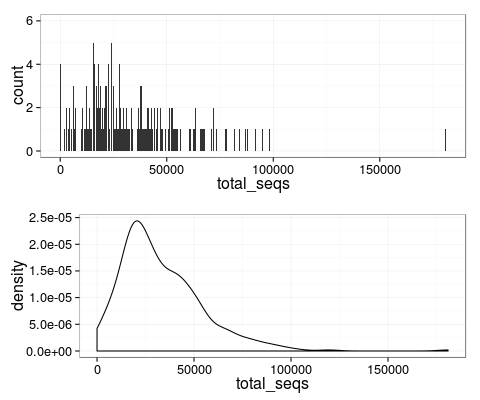

In [147]:
%%R -h 400

tbl.h.s = tbl.h %>%
    group_by(sample) %>%
    summarize(total_seqs = sum(count))


p = ggplot(tbl.h.s, aes(total_seqs)) +
    theme_bw() +
    theme(
        text = element_text(size=16)
        )
p1 = p + geom_histogram(binwidth=200) 
p2 = p + geom_density()

grid.arrange(p1,p2,ncol=1)

### Distribution fitting

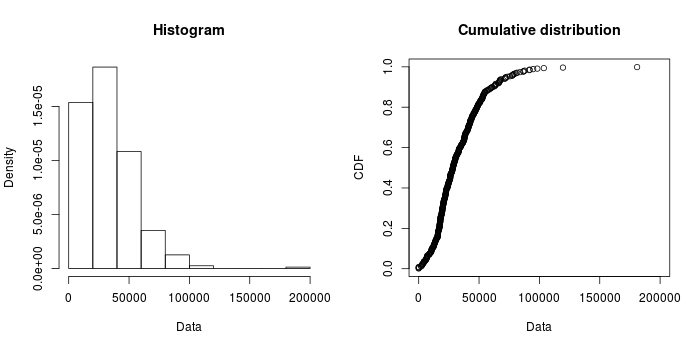

In [152]:
%%R -w 700 -h 350
plotdist(tbl.h.s$total_seqs)

summary statistics
------
min:  1   max:  180942 
median:  28263 
mean:  33211.14 
estimated sd:  21541.77 
estimated skewness:  1.627343 
estimated kurtosis:  8.871846 


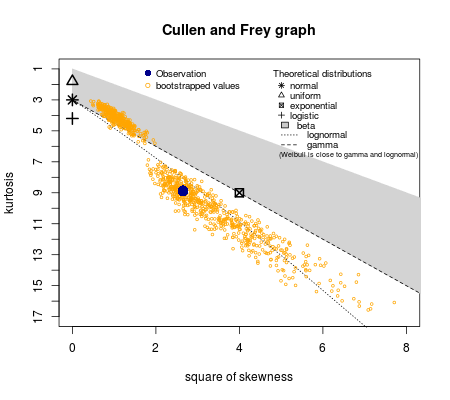

In [153]:
%%R -w 450 -h 400
descdist(tbl.h.s$total_seqs, boot=1000)

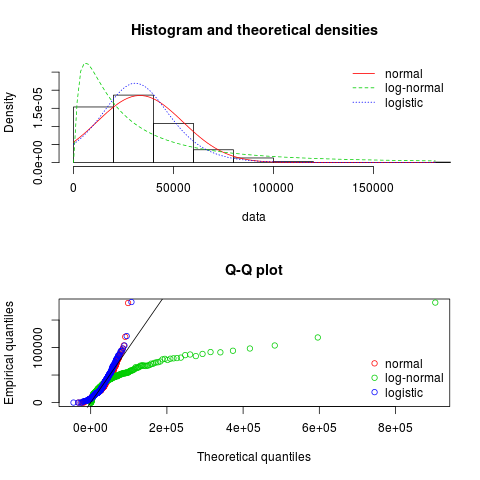

In [154]:
%%R
f.n = fitdist(tbl.h.s$total_seqs, 'norm')
f.ln = fitdist(tbl.h.s$total_seqs, 'lnorm')
f.ll = fitdist(tbl.h.s$total_seqs, 'logis')
#f.c = fitdist(tbl.s$count, 'cauchy')
f.list = list(f.n, f.ln, f.ll)

plot.legend = c('normal', 'log-normal', 'logistic')

par(mfrow = c(2,1))
denscomp(f.list, legendtext=plot.legend)
qqcomp(f.list, legendtext=plot.legend)

In [155]:
%%R

gofstat(list(f.n, f.ln, f.ll), fitnames=plot.legend)

Goodness-of-fit statistics
                                normal log-normal   logistic
Kolmogorov-Smirnov statistic 0.1010961  0.1971488 0.06645885
Cramer-von Mises statistic   1.2726290  4.4212031 0.58739094
Anderson-Darling statistic   7.5953687 26.8795505 4.84350229

Goodness-of-fit criteria
                                 normal log-normal logistic
Aikake's Information Criterion 9051.969   9300.198 9013.198
Bayesian Information Criterion 9059.937   9308.166 9021.166


In [156]:
%%R
summary(f.ln)

Fitting of the distribution ' lnorm ' by maximum likelihood 
Parameters : 
         estimate Std. Error
meanlog 10.113351 0.05983293
sdlog    1.192163 0.04230814
Loglikelihood:  -4648.099   AIC:  9300.198   BIC:  9308.166 
Correlation matrix:
        meanlog sdlog
meanlog       1     0
sdlog         0     1



#### Notes:

* best fit:
  * lognormal
    * mean = 10.113
    * sd = 1.192

## Does sample size correlate to buoyant density?

### Loading OTU table

In [201]:
%%R -i otuTableFile

tbl = read.delim(otuTableFile, sep='\t')

# filter
tbl = tbl %>%
    select(-ends_with('.NA')) %>%
    select(-starts_with('X0MC'))
tbl = tbl %>%
    gather('sample', 'count', 2:ncol(tbl)) %>%
    mutate(sample = gsub('^X', '', sample))

tbl %>% head

      OTUId           sample count
1  OTU.4776 12C.700.45.01.24   157
2  OTU.2864 12C.700.45.01.24     0
3  OTU.8170 12C.700.45.01.24     0
4  OTU.8762 12C.700.45.01.24     0
5  OTU.5223 12C.700.45.01.24     0
6 OTU.13091 12C.700.45.01.24     0


In [202]:
%%R
# summarize

tbl.s = tbl %>%
    group_by(sample) %>%
    summarize(total_count = sum(count))
tbl.s %>% head(n=3)

Source: local data frame [3 x 2]

            sample total_count
1 12C.000.14.05.01       21963
2 12C.000.14.05.02       94820
3 12C.000.14.05.03       25674


### Loading metadata

In [203]:
%%R -i metaDataFile

tbl.meta = read.delim(metaDataFile, sep='\t')
tbl.meta %>% head(n=3)

            Sample FractionNum Bulk Control CC X100 X700 H2O Day Density rep
1 12C.000.28.03.07           7    0       1  1    0    0   0  28  1.7646    
2 12C.000.28.03.08           8    0       1  1    0    0   0  28  1.7614    
3 12C.000.28.03.09           9    0       1  1    0    0   0  28  1.7537    
  contolVlabel Treatment
1      control    12C000
2      control    12C000
3      control    12C000


### Determining association

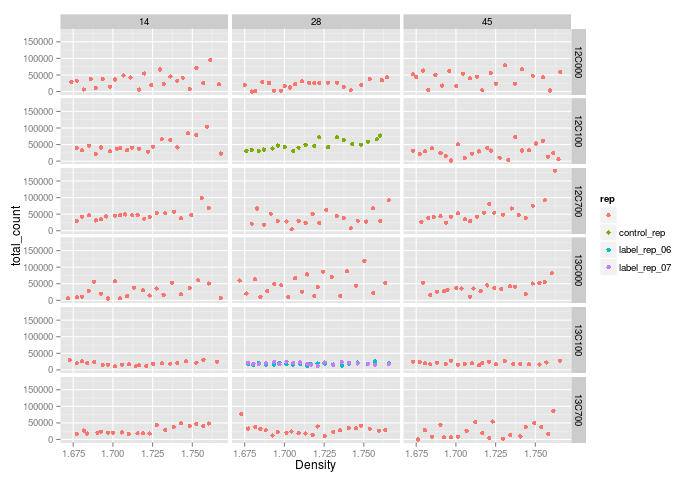

In [186]:
%%R -w 700

tbl.j = inner_join(tbl.s, tbl.meta, c('sample' = 'Sample')) 

ggplot(tbl.j, aes(Density, total_count, color=rep)) +
    geom_point() +
    facet_grid(Treatment ~ Day)

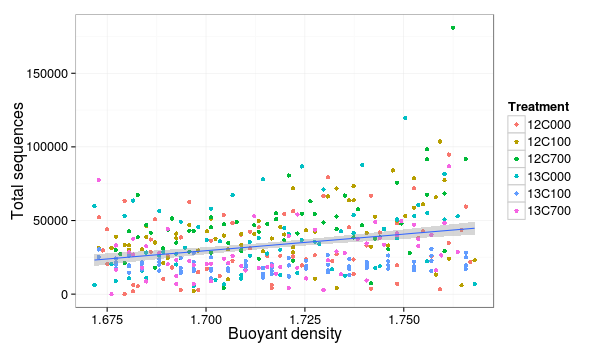

In [184]:
%%R -w 600 -h 350

ggplot(tbl.j, aes(Density, total_count)) +
    geom_point(aes(color=Treatment)) +
    geom_smooth(method='lm') +
    labs(x='Buoyant density', y='Total sequences') +
    theme_bw() +
    theme(
        text = element_text(size=16)
        )

## Number of taxa along the gradient

In [208]:
%%R 

tbl.s = tbl %>%
    filter(count > 0) %>%
    group_by(sample) %>%
    summarize(n_taxa = sum(count > 0))

tbl.j = inner_join(tbl.s, tbl.meta, c('sample' = 'Sample')) 
tbl.j %>% head(n=3)

Source: local data frame [3 x 14]

            sample n_taxa FractionNum Bulk Control CC X100 X700 H2O Day Density
1 12C.000.14.05.01    526           1    0       1  1    0    0   0  14  1.7668
2 12C.000.14.05.02   3458           2    0       1  1    0    0   0  14  1.7614
3 12C.000.14.05.03   2493           3    0       1  1    0    0   0  14  1.7570
Variables not shown: rep (fctr), contolVlabel (fctr), Treatment (fctr)


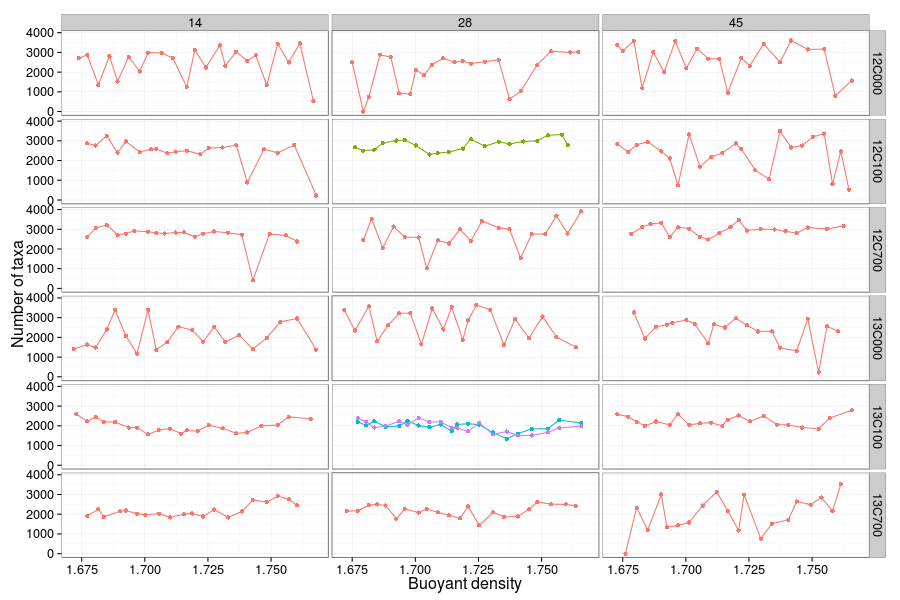

In [217]:
%%R -w 900 -h 600

ggplot(tbl.j, aes(Density, n_taxa, fill=rep, color=rep)) +
    #geom_area(stat='identity', alpha=0.5, position='dodge') +
    geom_point() +
    geom_line() +
    labs(x='Buoyant density', y='Number of taxa') +
    facet_grid(Treatment ~ Day) +
    theme_bw() +
    theme( 
        text = element_text(size=16),
        legend.position = 'none'
    )

#### Notes:

* Many taxa out to the tails of the gradient.
* It seems that the DNA fragments were quite diffuse in the gradients.

# Total abundance of each target taxon: bulk soil approach

* Getting relative abundances from bulk soil samples
  * This has the caveat of likely undersampling richness vs using all gradient fraction samples.
    * i.e., veil line effect

In [134]:
%%R -i otuTableFile
# loading OTU table
tbl = read.delim(otuTableFile, sep='\t')

# filter
tbl = tbl %>%
    select(matches('OTUId'), ends_with('.NA'))

tbl %>% ncol %>% print
tbl[1:4,1:4]

[1] 71
     OTUId X00C.000.14.09.NA X13C.100.14.08.NA X12C.700.28.04.NA
1 OTU.4776                60                88                54
2 OTU.2864                 1                 0                 0
3 OTU.8170                 0                 0                 0
4 OTU.8762                 0                 0                 0


In [135]:
%%R
# long table format w/ selecting samples of interest
tbl.h = tbl %>% 
    gather('sample', 'count', 2:ncol(tbl)) %>%
    separate(sample, c('isotope','treatment','day','rep','fraction'), sep='\\.', remove=F) %>%
    filter(sample %in% samples.to.use,
           count > 0) 
tbl.h %>% head    

      OTUId            sample isotope treatment day rep fraction count
1  OTU.4776 X13C.700.28.06.NA    X13C       700  28  06       NA    26
2   OTU.611 X13C.700.28.06.NA    X13C       700  28  06       NA     2
3   OTU.961 X13C.700.28.06.NA    X13C       700  28  06       NA     1
4   OTU.527 X13C.700.28.06.NA    X13C       700  28  06       NA     1
5 OTU.12349 X13C.700.28.06.NA    X13C       700  28  06       NA     1
6   OTU.262 X13C.700.28.06.NA    X13C       700  28  06       NA     9


In [136]:
%%R
message('Number of samples: ', tbl.h$sample %>% unique %>% length)
message('Number of OTUs: ', tbl.h$OTUId %>% unique %>% length)

Number of samples: 6
Number of OTUs: 4252


In [137]:
%%R

tbl.hs = tbl.h %>%
    group_by(OTUId) %>%
    summarize(
        total_count = sum(count),
        mean_count = mean(count),
        median_count = median(count),
        sd_count = sd(count)
    ) %>%
    filter(total_count > 0)

tbl.hs %>% head

Source: local data frame [6 x 5]

     OTUId total_count mean_count median_count    sd_count
1    OTU.1        1590  265.00000          187 173.4785289
2   OTU.10          80   13.33333           12   6.0553007
3  OTU.100         148   24.66667           22  15.7437818
4 OTU.1000           2    1.00000            1   0.0000000
5 OTU.1001           7    1.40000            1   0.5477226
6 OTU.1002          10    2.00000            2   0.7071068


### For each sample, writing a table of OTU_ID and count

In [140]:
%%R -i workDir
setwd(workDir)

samps = tbl.h$sample %>% unique %>% as.vector

for(samp in samps){
    outFile = paste(c(samp, 'OTU.txt'), collapse='_')
    
    tbl.p = tbl.h %>% 
        filter(sample == samp, count > 0)
    
    write.table(tbl.p, outFile, sep='\t', quote=F, row.names=F)
    
    message('Table written: ', outFile)
    message('  Number of OTUs: ', tbl.p %>% nrow)
    }

Table written: X13C.700.28.06.NA_OTU.txt
  Number of OTUs: 1917
Table written: X13C.700.14.08.NA_OTU.txt
  Number of OTUs: 2677
Table written: X12C.700.28.03.NA_OTU.txt
  Number of OTUs: 2194
Table written: X12C.700.45.01.NA_OTU.txt
  Number of OTUs: 2239
Table written: X12C.700.14.05.NA_OTU.txt
  Number of OTUs: 2170
Table written: X13C.700.45.01.NA_OTU.txt
  Number of OTUs: 1858


# Making directories for simulations

In [133]:
p = os.path.join(workDir, '*_OTU.txt')
files = glob.glob(p)

baseDir = os.path.split(workDir)[0]
newDirs = [os.path.split(x)[1].rstrip('.NA_OTU.txt') for x in files]
newDirs = [os.path.join(baseDir, x) for x in newDirs]

for newDir,f in zip(newDirs, files):
    if not os.path.isdir(newDir):
        print 'Making new directory: {}'.format(newDir)
        os.makedirs(newDir)
    else:
        print 'Directory exists: {}'.format(newDir)
    # symlinking file
    linkPath = os.path.join(newDir, os.path.split(f)[1])
    if not os.path.islink(linkPath):
        os.symlink(f, linkPath)

Directory exists: /home/nick/notebook/SIPSim/dev/priming_exp/X13C.700.28.06
Directory exists: /home/nick/notebook/SIPSim/dev/priming_exp/X12C.700.28.03
Directory exists: /home/nick/notebook/SIPSim/dev/priming_exp/X13C.700.14.08
Directory exists: /home/nick/notebook/SIPSim/dev/priming_exp/X13C.700.45.01
Directory exists: /home/nick/notebook/SIPSim/dev/priming_exp/X12C.700.45.01
Directory exists: /home/nick/notebook/SIPSim/dev/priming_exp/X12C.700.14.05


# Rank-abundance distribution for each sample

In [7]:
%%R -i otuTableFile

tbl = read.delim(otuTableFile, sep='\t')

# filter
tbl = tbl %>%
    select(matches('OTUId'), ends_with('.NA'))

tbl %>% ncol %>% print
tbl[1:4,1:4]

[1] 71
     OTUId X00C.000.14.09.NA X13C.100.14.08.NA X12C.700.28.04.NA
1 OTU.4776                60                88                54
2 OTU.2864                 1                 0                 0
3 OTU.8170                 0                 0                 0
4 OTU.8762                 0                 0                 0


In [9]:
%%R
# long table format w/ selecting samples of interest
tbl.h = tbl %>% 
    gather('sample', 'count', 2:ncol(tbl)) %>%
    separate(sample, c('isotope','treatment','day','rep','fraction'), sep='\\.', remove=F) %>%
    filter(sample %in% samples.to.use,
           count > 0) 
tbl.h %>% head    

      OTUId            sample isotope treatment day rep fraction count
1  OTU.4776 X13C.700.28.06.NA    X13C       700  28  06       NA    26
2   OTU.611 X13C.700.28.06.NA    X13C       700  28  06       NA     2
3   OTU.961 X13C.700.28.06.NA    X13C       700  28  06       NA     1
4   OTU.527 X13C.700.28.06.NA    X13C       700  28  06       NA     1
5 OTU.12349 X13C.700.28.06.NA    X13C       700  28  06       NA     1
6   OTU.262 X13C.700.28.06.NA    X13C       700  28  06       NA     9


In [25]:
%%R
# ranks of relative abundances

tbl.r = tbl.h %>%
    group_by(sample) %>%
    mutate(perc_rel_abund = count / sum(count) * 100,
           rank = row_number(-perc_rel_abund)) %>%
    unite(day_rep, day, rep, sep='-')
tbl.r %>% as.data.frame %>% head(n=3)

     OTUId            sample isotope treatment day_rep fraction count
1 OTU.4776 X13C.700.28.06.NA    X13C       700   28-06       NA    26
2  OTU.611 X13C.700.28.06.NA    X13C       700   28-06       NA     2
3  OTU.961 X13C.700.28.06.NA    X13C       700   28-06       NA     1
  perc_rel_abund rank
1    0.140479793  143
2    0.010806138  927
3    0.005403069 1231


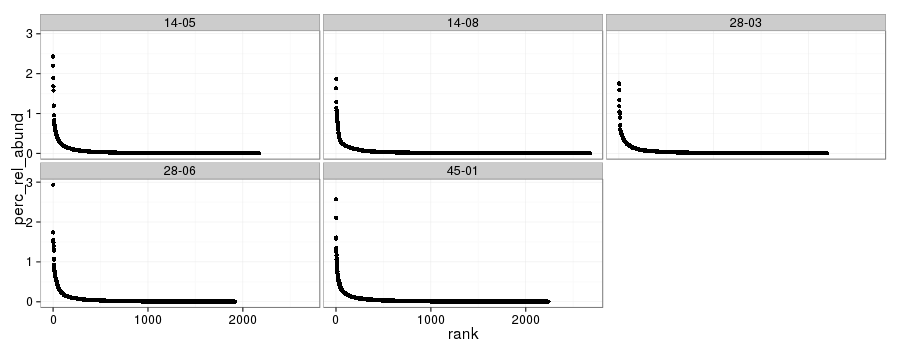

In [27]:
%%R -w 900 -h 350


ggplot(tbl.r, aes(rank, perc_rel_abund)) +
    geom_point() +
#    labs(x='Buoyant density', y='Number of taxa') +
    facet_wrap(~ day_rep) +
    theme_bw() +
    theme( 
        text = element_text(size=16),
        legend.position = 'none'
    )

## Taxon abundance range for each sample-fraction

In [22]:
%%R -i otuTableFile

tbl = read.delim(otuTableFile, sep='\t')

# filter
tbl = tbl %>%
    select(-ends_with('.NA')) %>%
    select(-starts_with('X0MC'))
tbl = tbl %>%
    gather('sample', 'count', 2:ncol(tbl)) %>%
    mutate(sample = gsub('^X', '', sample))

tbl %>% head

      OTUId           sample count
1  OTU.4776 12C.700.45.01.24   157
2  OTU.2864 12C.700.45.01.24     0
3  OTU.8170 12C.700.45.01.24     0
4  OTU.8762 12C.700.45.01.24     0
5  OTU.5223 12C.700.45.01.24     0
6 OTU.13091 12C.700.45.01.24     0


In [43]:
%%R

tbl.ar = tbl %>%
    #mutate(fraction = gsub('.+\\.', '', sample) %>% as.numeric) %>%
    #mutate(treatment = gsub('(.+)\\..+', '\\1', sample)) %>%
    group_by(sample) %>%
    mutate(rel_abund = count / sum(count)) %>% 
    summarize(abund_range = max(rel_abund) - min(rel_abund)) %>%
    ungroup() %>%
    separate(sample, c('isotope','treatment','day','rep','fraction'), sep='\\.', remove=F)

tbl.ar %>% head(n=3)

Source: local data frame [3 x 7]

            sample isotope treatment day rep fraction abund_range
1 12C.000.14.05.01     12C       000  14  05       01  0.14542640
2 12C.000.14.05.02     12C       000  14  05       02  0.01763341
3 12C.000.14.05.03     12C       000  14  05       03  0.01686531


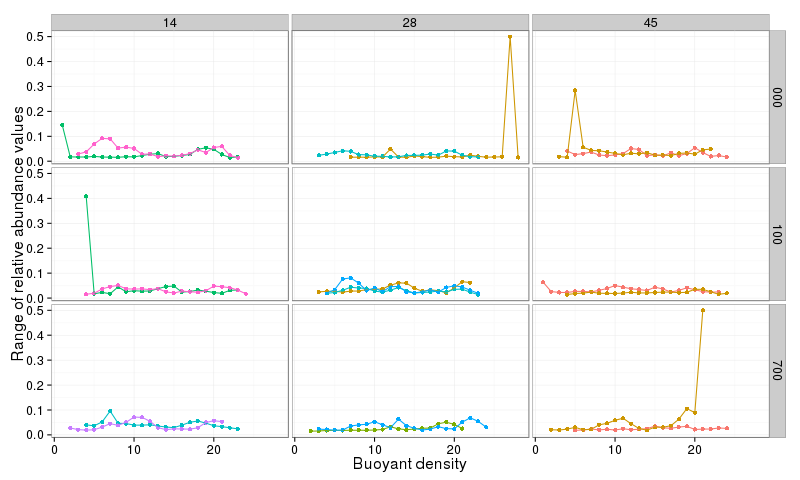

In [48]:
%%R -w 800

tbl.ar = tbl.ar %>%
    mutate(fraction = as.numeric(fraction))

ggplot(tbl.ar, aes(fraction, abund_range, fill=rep, color=rep)) +
    geom_point() +
    geom_line() +
    labs(x='Buoyant density', y='Range of relative abundance values') +
    facet_grid(treatment ~ day) +
    theme_bw() +
    theme( 
        text = element_text(size=16),
        legend.position = 'none'
    )

# Total abundance of each target taxon: all fraction samples approach

* Getting relative abundances from all fraction samples for the gradient
  * I will need to calculate (mean|max?) relative abundances for each taxon and then re-scale so that cumsum = 1

In [96]:
%%R -i otuTableFile
# loading OTU table
tbl = read.delim(otuTableFile, sep='\t') %>%
    select(-ends_with('.NA'))

tbl.h = tbl %>% 
    gather('sample', 'count', 2:ncol(tbl)) %>%
    separate(sample, c('isotope','treatment','day','rep','fraction'), sep='\\.', remove=F)
tbl.h %>% head  

      OTUId            sample isotope treatment day rep fraction count
1  OTU.4776 X12C.700.45.01.24    X12C       700  45  01       24   157
2  OTU.2864 X12C.700.45.01.24    X12C       700  45  01       24     0
3  OTU.8170 X12C.700.45.01.24    X12C       700  45  01       24     0
4  OTU.8762 X12C.700.45.01.24    X12C       700  45  01       24     0
5  OTU.5223 X12C.700.45.01.24    X12C       700  45  01       24     0
6 OTU.13091 X12C.700.45.01.24    X12C       700  45  01       24     0


In [100]:
%%R
# basename of fractions
samples.to.use.base = gsub('\\.[0-9]+\\.NA', '', samples.to.use)

samps = tbl.h$sample %>% unique

fracs = sapply(samples.to.use.base, function(x) grep(x, samps, value=TRUE))

for (n in names(fracs)){
    n.frac = length(fracs[[n]])
    cat(n, '-->', 'Number of fraction samples: ', n.frac, '\n')
}

X12C.700.14 --> Number of fraction samples:  20 
X12C.700.28 --> Number of fraction samples:  20 
X12C.700.45 --> Number of fraction samples:  20 
X13C.700.14 --> Number of fraction samples:  20 
X13C.700.28 --> Number of fraction samples:  22 
X13C.700.45 --> Number of fraction samples:  20 


In [103]:
%%R
# function for getting mean OTU abundance from all fractions 
OTU.abund = function(samples, otu.long){
    otu.rel.abund = otu.long %>%
        filter(sample %in% samples,
               count > 0) %>%
        ungroup() %>%
        group_by(sample) %>%
        mutate(total_count = sum(count)) %>%
        ungroup() %>%
        mutate(perc_abund = count / total_count * 100) %>%
        group_by(OTUId) %>%
        summarize(mean_perc_abund = mean(perc_abund),
                  median_perc_abund = median(perc_abund),
                  max_perc_abund = max(perc_abund)) 
    
    return(otu.rel.abund)
}

## calling function
otu.rel.abund = lapply(fracs, OTU.abund, otu.long=tbl.h)
otu.rel.abund = do.call(rbind, otu.rel.abund) %>% as.data.frame
otu.rel.abund$sample = gsub('\\.[0-9]+$', '', rownames(otu.rel.abund))
otu.rel.abund %>% head

                  OTUId mean_perc_abund median_perc_abund max_perc_abund
X12C.700.14.1     OTU.1     3.827532325       3.926317300    5.603168720
X12C.700.14.2    OTU.10     0.048631000       0.048182090    0.085456173
X12C.700.14.3   OTU.100     0.308850910       0.312166472    0.508460092
X12C.700.14.4  OTU.1000     0.013548909       0.013883827    0.024440914
X12C.700.14.5 OTU.10000     0.001464408       0.001464408    0.001464408
X12C.700.14.6  OTU.1001     0.005668025       0.005251645    0.016415420
                   sample
X12C.700.14.1 X12C.700.14
X12C.700.14.2 X12C.700.14
X12C.700.14.3 X12C.700.14
X12C.700.14.4 X12C.700.14
X12C.700.14.5 X12C.700.14
X12C.700.14.6 X12C.700.14


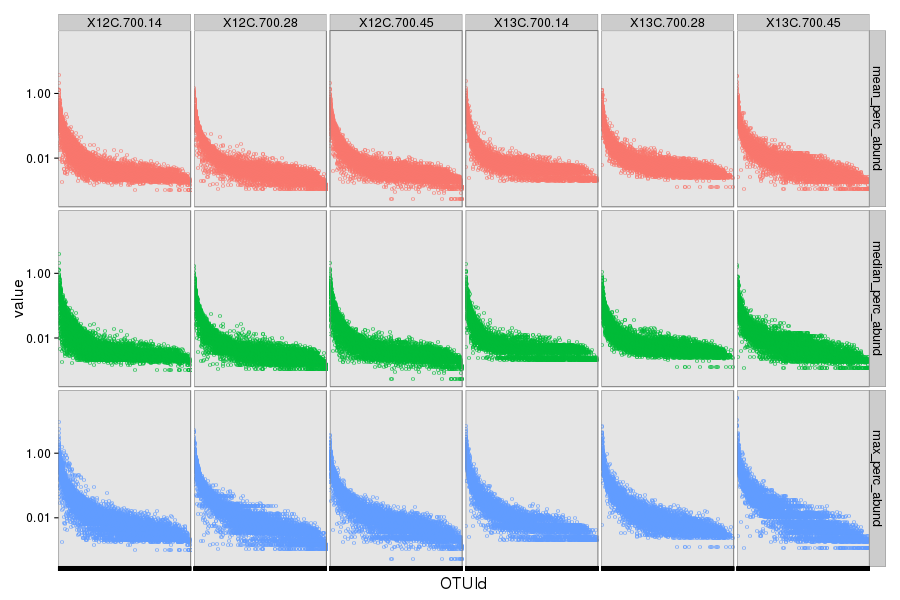

In [118]:
%%R -h 600 -w 900
# plotting
otu.rel.abund.l = otu.rel.abund %>%
    gather('abund_stat', 'value', mean_perc_abund, median_perc_abund, max_perc_abund)

otu.rel.abund.l$OTUId = reorder(otu.rel.abund.l$OTUId, -otu.rel.abund.l$value)

ggplot(otu.rel.abund.l, aes(OTUId, value, color=abund_stat)) +
    geom_point(shape='O', alpha=0.7) +
    scale_y_log10() +
    facet_grid(abund_stat ~ sample) +
    theme_bw() +
    theme(
        text = element_text(size=16),
        axis.text.x = element_blank(),
        legend.position = 'none'
        )

### For each sample, writing a table of OTU_ID and count

In [123]:
%%R -i workDir
setwd(workDir)



# each sample is a file
samps = otu.rel.abund.l$sample %>% unique %>% as.vector

for(samp in samps){
    outFile = paste(c(samp, 'frac_OTU.txt'), collapse='_')
    
    tbl.p = otu.rel.abund %>% 
        filter(sample == samp, mean_perc_abund > 0)
    
    write.table(tbl.p, outFile, sep='\t', quote=F, row.names=F)
    
    cat('Table written: ', outFile, '\n')
    cat('  Number of OTUs: ', tbl.p %>% nrow, '\n')
    }

Table written:  X12C.700.14_frac_OTU.txt 
  Number of OTUs:  6606 
Table written:  X12C.700.28_frac_OTU.txt 
  Number of OTUs:  6896 
Table written:  X12C.700.45_frac_OTU.txt 
  Number of OTUs:  6901 
Table written:  X13C.700.14_frac_OTU.txt 
  Number of OTUs:  6005 
Table written:  X13C.700.28_frac_OTU.txt 
  Number of OTUs:  6238 
Table written:  X13C.700.45_frac_OTU.txt 
  Number of OTUs:  6325 


# A broader taxon distribution with increased abundance?

* Overloading molecules at one spot in the gradient, leading to more diffusion?